In [2]:
import nltk
import random
import json
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report

In [3]:
import numpy as np
import sklearn
import pandas as pd
import nltk
import tensorflow as tf

print("NumPy version:", np.__version__)
print("scikit-learn version:", sklearn.__version__)
print("pandas version:", pd.__version__)
print("nltk version:", nltk.__version__)
print("TensorFlow version:", tf.__version__)


NumPy version: 1.26.4
scikit-learn version: 1.2.2
pandas version: 2.2.3
nltk version: 3.9.1
TensorFlow version: 2.18.0


In [4]:
# Đường dẫn tới file CSV của bạn
file_path = '/kaggle/input/bitext-gen-ai-chatbot-customer-support-dataset/Bitext_Sample_Customer_Support_Training_Dataset_27K_responses-v11.csv'

# Đọc file CSV
df = pd.read_csv(file_path)

# Lọc 3 cột: instruction, intent, response
df = df[[ 'intent', 'instruction','response']]

# Hiển thị 5 dòng đầu tiên để kiểm tra
print(df.head())

         intent                                        instruction  \
0  cancel_order   question about cancelling order {{Order Number}}   
1  cancel_order  i have a question about cancelling oorder {{Or...   
2  cancel_order    i need help cancelling puchase {{Order Number}}   
3  cancel_order         I need to cancel purchase {{Order Number}}   
4  cancel_order  I cannot afford this order, cancel purchase {{...   

                                            response  
0  I've understood you have a question regarding ...  
1  I've been informed that you have a question ab...  
2  I can sense that you're seeking assistance wit...  
3  I understood that you need assistance with can...  
4  I'm sensitive to the fact that you're facing f...  


In [ ]:
# # Function to perform synonym replacement
# def synonym_replacement(tokens, limit):
#     augmented_sentences = []
#     for i in range(len(tokens)):
#         synonyms = []
#         for syn in wordnet.synsets(tokens[i]):
#             for lemma in syn.lemmas():
#                 synonyms.append(lemma.name())
#         if len(synonyms) > 0:
#             num_augmentations = min(limit, len(synonyms))
#             sampled_synonyms = random.sample(synonyms, num_augmentations)
#             for synonym in sampled_synonyms:
#                 augmented_tokens = tokens[:i] + [synonym] + tokens[i+1:]
#                 augmented_sentences.append(' '.join(augmented_tokens))
#     return augmented_sentences

In [5]:
#Loại bỏ các con số
def remove_number(text):
    result = re.sub(r'\d+', '', text)
    return result

# #Loại bỏ các dấu câu
def remove_punctuation(text):
    text = text.replace(",", " ").replace(".", " ") \
               .replace(";", " ").replace("“", " ") \
               .replace(":", " ").replace("”", " ") \
               .replace('"', " ").replace("'", " ") \
               .replace("!", " ").replace("?", " ") \
               .replace("-", " ").replace("=", " ") \
               .replace(")", " ").replace("(", " ") \
               .replace("~", " ").replace("!", " ") \
               .replace("@", " ").replace("#", " ") \
               .replace("$", " ").replace("%", " ") \
               .replace("^", " ").replace("&", " ") \
               .replace("*", " ").replace("_", " ") \
               .replace("+", " ").replace("=", " ") \
               .replace("{", " ").replace("}", " ") \
               .replace("[", " ").replace("]", " ") \
               .replace(":", " ").replace(";", " ") \
               .replace('"', " ").replace("'", " ") \
               .replace("<", " ").replace(">", " ") \
               .replace(",", " ").replace(".", " ") \
               .replace("/", " ").replace("?", " ")
                 # Có thể thêm dấu cách ở cuối nếu muốn
    return text

#Loại bỏ khoảng trắng thừa
def remove_whitespace(text):
    return  " ".join(text.split())

# Bỏ bớt các chữ cái giống nhau liên tiếp( Vd: quaaa -> qua)
def remove_similarletter(text):
    text = re.sub(r'([A-Z])\1+', lambda m: m.group(1).upper(), text, flags=re.IGNORECASE)
    return text

import re
remove_emoji = re.compile("["
                u"\U0001F600-\U0001F64F"
                u"\U0001F300-\U0001F5FF"
                u"\U0001F680-\U0001F6FF"
                u"\U0001F1E0-\U0001F1FF"
                u"\U00002702-\U000027B0"
                u"\U000024C2-\U0001F251"
                u"\U0001f926-\U0001f937"
                u'\U00010000-\U0010ffff'
                u"\u200d"
                u"\u2640-\u2642"
                u"\u2600-\u2B55"
                u"\u23cf"
                u"\u23e9"
                u"\u231a"
                u"\u3030"
                u"\ufe0f"
    "]+", flags=re.UNICODE) # Unicode emojis.

In [6]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Tải tài nguyên từ nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# Tải stopwords tiếng Anh
english_stopwords = set(stopwords.words('english'))

# Khởi tạo lemmatizer
lemmatizer = WordNetLemmatizer()


text_data = []
labels = []
# limit_per_tag = 40

# Nhóm theo intent
grouped = df.groupby('intent')

for tag, group in grouped:
    augmented_sentences_per_tag = 0
    for instruction in group['instruction']:
        
        instruction = str(instruction).lower()

        # Tiền xử lý dữ liệu
        instruction = remove_number(instruction)
        instruction = remove_punctuation(instruction)
        instruction = remove_whitespace(instruction)
        instruction = remove_similarletter(instruction)
        instruction = re.sub(remove_emoji, " ",instruction)

        # Tokenize và loại bỏ stopwords, lemmatize
        tokens = nltk.word_tokenize(instruction)
        filtered_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in english_stopwords and token.isalpha()]
        
        if filtered_tokens:
            text_data.append(' '.join(filtered_tokens))
            labels.append(tag)

            # augmented_sentences = synonym_replacement(filtered_tokens, limit_per_tag - augmented_sentences_per_tag)
            # for augmented_sentence in augmented_sentences:
            #     text_data.append(augmented_sentence)
            #     labels.append(tag)
            #     augmented_sentences_per_tag += 1
            #     if augmented_sentences_per_tag >= limit_per_tag:
            #         break

print(len(text_data))
print(len(labels))


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


26872
26872


In [ ]:
# vectorizer = TfidfVectorizer()
# X = vectorizer.fit_transform(text_data)
# y = labels

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(text_data)
sequences = tokenizer.texts_to_sequences(text_data)

# Padding
max_len = 100
X = pad_sequences(sequences, maxlen=max_len, padding='post')

# Encode label
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

# Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
print(max_len)

In [8]:
import matplotlib.pyplot as plt

def plot_training_history(history, model_name="Model"):
    history_dict = history.history

    loss = history_dict.get('loss', [])
    val_loss = history_dict.get('val_loss', [])
    acc = history_dict.get('accuracy', [])
    val_acc = history_dict.get('val_accuracy', [])

    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(12, 5))
    plt.suptitle(f"Training History for {model_name}", fontsize=16)

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stop = EarlyStopping(monitor="val_loss", mode="min",min_delta=1e-5,
                            verbose=1, patience=5, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1)


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

vocab_size = len(tokenizer.word_index) + 1  # +1 cho padding
embedding_dim = 100

cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))
cnn_model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.3))
cnn_model.add(Dense(len(np.unique(y)), activation='softmax'))

cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

cnn_model.summary()

I0000 00:00:1748573207.990398      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [10]:

# Train#ModelCheckpoint nhằm lưu lại mô hình tại thời điểm có giá trị mất mát trên tập validation thấp nhất
callback_model = tf.keras.callbacks.ModelCheckpoint('/kaggle/working/cnn_model.keras', monitor='val_loss')
cnn_history = cnn_model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1,callbacks=[early_stop,callback_model])


Epoch 1/30


I0000 00:00:1748572666.410490      95 service.cc:148] XLA service 0x7a182800b160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748572666.410984      95 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1748572666.782471      95 cuda_dnn.cc:529] Loaded cuDNN version 90300


 65/605 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0740 - loss: 3.2646

I0000 00:00:1748572669.662130      95 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


605/605 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.4438 - loss: 1.9787 - val_accuracy: 0.9912 - val_loss: 0.0447
Epoch 2/30
605/605 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9607 - loss: 0.1369 - val_accuracy: 0.9940 - val_loss: 0.0197
Epoch 3/30
605/605 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9841 - loss: 0.0562 - val_accuracy: 0.9953 - val_loss: 0.0141
Epoch 4/30
605/605 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9900 - loss: 0.0383 - val_accuracy: 0.9953 - val_loss: 0.0124
Epoch 5/30
605/605 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9932 - loss: 0.0257 - val_accuracy: 0.9963 - val_loss: 0.0136
Epoch 6/30
605/605 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9942 - loss: 0.0208 - val_accuracy: 0.9940 - val_loss: 0.0193
Epoch 7/30
605/605 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9953 - loss: 0.0160 - val_accuracy: 0.9953 - val_loss: 0.0148
Epoch 8/30
605/605 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9963 - loss: 0.0144 - val_accuracy: 0.9953 - val

In [11]:
# 2) Đánh giá loss/accuracy chung trên test set (tuỳ chọn)
loss, acc = cnn_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f} - Test Accuracy: {acc:.4f}")

# 3) Dự đoán nhãn trên X_test
y_pred_proba = cnn_model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# 4) In classification report
report = classification_report(
    y_test,
    y_pred,
    target_names=label_encoder.classes_
)
print( report)

Test Loss: 0.0209 - Test Accuracy: 0.9946
                          precision    recall  f1-score   support

            cancel_order       1.00      0.97      0.98       187
            change_order       0.99      0.99      0.99       187
 change_shipping_address       0.99      1.00      0.99       216
  check_cancellation_fee       1.00      1.00      1.00       199
           check_invoice       0.98      1.00      0.99       192
   check_payment_methods       1.00      1.00      1.00       206
     check_refund_policy       1.00      1.00      1.00       200
               complaint       1.00      1.00      1.00       203
contact_customer_service       1.00      0.99      0.99       208
     contact_human_agent       0.99      1.00      0.99       201
          create_account       0.99      0.99      0.99       217
          delete_account       0.99      0.99      0.99       178
        delivery_options       1.00      1.00      1.00       218
         delivery_period       0.

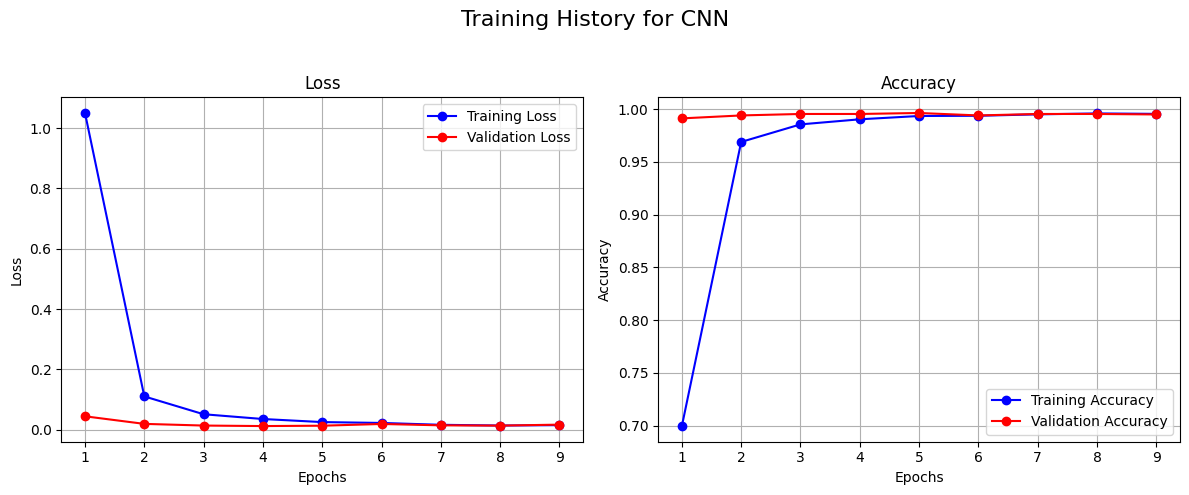

In [12]:
# Vẽ lại lịch sử training
plot_training_history(cnn_history, model_name="CNN")

In [9]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout,GlobalMaxPooling1D,Attention

# Tham số (giữ nguyên từ code gốc)
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 128
max_length = 100
num_classes = len(np.unique(y))

# Input
inputs = Input(shape=(max_length,))
embedding_layer = Embedding(vocab_size, embedding_dim)(inputs)
# Giả sử x đã qua Embedding với return_sequences=True
lstm_out = LSTM(128, return_sequences=True)(embedding_layer)

# Self-Attention: query, key, value đều dùng output của LSTM
attn = Attention(name="attention_layer")([lstm_out, lstm_out])  
# attn shape = (batch_size, timesteps, units)

# Bạn có thể pool tiếp, ví dụ GlobalAveragePooling1D hoặc GlobalMaxPooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D
pooled = GlobalAveragePooling1D()(attn)

# Rồi đến Dense → output như bình thường
x = Dense(64, activation='relu')(pooled)
outputs = Dense(num_classes, activation='softmax')(x)

lstm_model = Model(inputs, outputs)
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.summary()

I0000 00:00:1748572824.072514      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 100)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 100, 128)       │        323,200 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 100, 128)       │        131,584 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_layer           │ (None, 100, 128)       │              0 │ lstm[0][0], lstm[0][0] │
│ (Attention)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 128)            │              0 │ attention_layer[0][0]  │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │          8,256 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 27)             │          1,755 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 464,795 (1.77 MB)

 Trainable params: 464,795 (1.77 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
#ModelCheckpoint nhằm lưu lại mô hình tại thời điểm có giá trị mất mát trên tập validation thấp nhất
callback_model = tf.keras.callbacks.ModelCheckpoint('/kaggle/working/lstm_model.keras', monitor='val_loss')
# Train
lstm_history = lstm_model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1,callbacks=[early_stop,callback_model])


Epoch 1/30


I0000 00:00:1748572832.094515      93 cuda_dnn.cc:529] Loaded cuDNN version 90300


605/605 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.0733 - loss: 3.0967 - val_accuracy: 0.5400 - val_loss: 1.3793
Epoch 2/30
605/605 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7026 - loss: 0.9239 - val_accuracy: 0.9809 - val_loss: 0.0926
Epoch 3/30
605/605 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9878 - loss: 0.0605 - val_accuracy: 0.9879 - val_loss: 0.0468
Epoch 4/30
605/605 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9953 - loss: 0.0215 - val_accuracy: 0.9912 - val_loss: 0.0463
Epoch 5/30
605/605 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9972 - loss: 0.0108 - val_accuracy: 0.9898 - val_loss: 0.0384
Epoch 6/30
605/605 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9986 - loss: 0.0070 - val_accuracy: 0.9912 - val_loss: 0.0497
Epoch 7/30
605/605 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9979 - loss: 0.0077 - val_accuracy: 0.9926 - val_loss: 0.0403
Epoch 8/30
605/605 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9992 - loss: 0.0034 - val_accuracy: 0.9930 - val_

In [11]:
# 2) Đánh giá loss/accuracy chung trên test set (tuỳ chọn)
loss, acc = lstm_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f} - Test Accuracy: {acc:.4f}")

# 3) Dự đoán nhãn trên X_test
y_pred_proba = lstm_model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# 4) In classification report
report = classification_report(
    y_test,
    y_pred,
    target_names=label_encoder.classes_
)
print( report)

Test Loss: 0.0379 - Test Accuracy: 0.9909
                          precision    recall  f1-score   support

            cancel_order       1.00      0.97      0.98       187
            change_order       0.97      0.99      0.98       187
 change_shipping_address       0.99      0.99      0.99       216
  check_cancellation_fee       1.00      0.99      1.00       199
           check_invoice       0.98      0.99      0.99       192
   check_payment_methods       1.00      1.00      1.00       206
     check_refund_policy       0.99      0.99      0.99       200
               complaint       1.00      1.00      1.00       203
contact_customer_service       1.00      0.99      0.99       208
     contact_human_agent       0.99      0.99      0.99       201
          create_account       1.00      0.99      0.99       217
          delete_account       0.99      0.97      0.98       178
        delivery_options       0.99      1.00      1.00       218
         delivery_period       0.

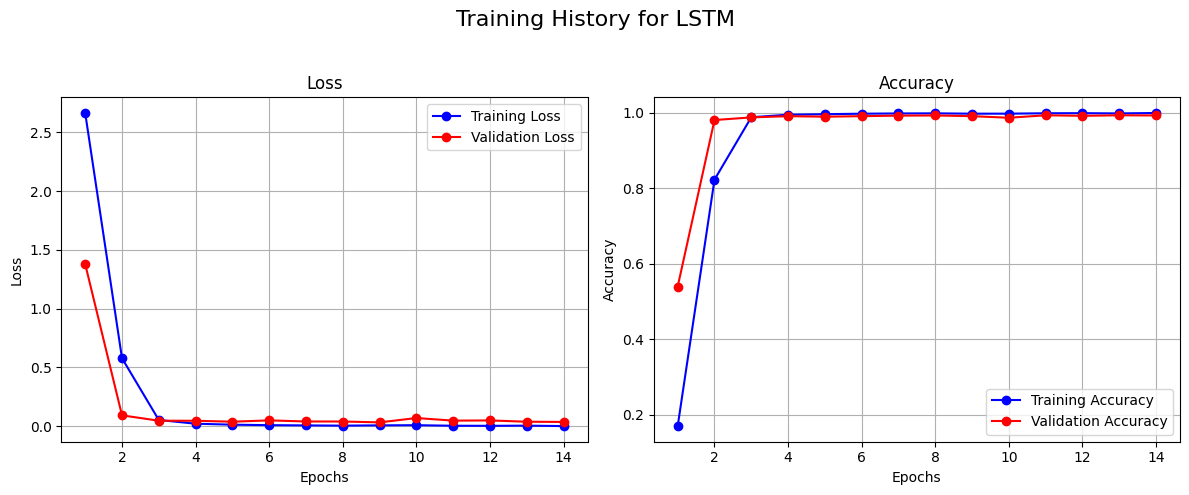

In [12]:
plot_training_history(lstm_history, model_name="LSTM")

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout, Attention, Concatenate
import tensorflow as tf

# Tham số
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 128
max_length=100

# Input
inputs = Input(shape=(max_length,))
embedding_layer = Embedding(vocab_size, embedding_dim)(inputs)

# BiLSTM
lstm = Bidirectional(LSTM(64, return_sequences=True))(embedding_layer)

# Attention
attention = tf.keras.layers.Attention()([lstm, lstm])
attention_concat = Concatenate()([lstm, attention])
pool = tf.keras.layers.GlobalMaxPooling1D()(attention_concat)

# Dense layers
dense = Dense(128, activation='relu')(pool)
dropout = Dropout(0.5)(dense)
dense = Dense(64, activation='relu')(dropout)
dropout = Dropout(0.5)(dense)
outputs = Dense(len(np.unique(y)), activation='softmax')(dropout)

# Tạo và compile model
bilstm = Model(inputs=inputs, outputs=outputs)
bilstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
bilstm.summary()

I0000 00:00:1748573006.558641      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 100)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 100, 128)       │        323,200 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 100, 128)       │         98,816 │ embedding[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention (Attention)     │ (None, 100, 128)       │              0 │ bidirectional[0][0],   │
│                           │                        │                │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 100, 256)       │              0 │ bidirectional[0][0],   │
│                           │                        │                │ attention[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d      │ (None, 256)            │              0 │ concatenate[0][0]      │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │         32,896 │ global_max_pooling1d[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │          8,256 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64)             │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 27)             │          1,755 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 464,923 (1.77 MB)

 Trainable params: 464,923 (1.77 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
#ModelCheckpoint nhằm lưu lại mô hình tại thời điểm có giá trị mất mát trên tập validation thấp nhất
callback_model = tf.keras.callbacks.ModelCheckpoint('/kaggle/working/bilstm_model.keras', monitor='val_loss')
# Train
bilstm_history = bilstm.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1,callbacks=[early_stop,callback_model])


Epoch 1/20


I0000 00:00:1748573016.393034      92 cuda_dnn.cc:529] Loaded cuDNN version 90300


605/605 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.2050 - loss: 2.6078 - val_accuracy: 0.9656 - val_loss: 0.1389
Epoch 2/20
605/605 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.8864 - loss: 0.3674 - val_accuracy: 0.9870 - val_loss: 0.0418
Epoch 3/20
605/605 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9532 - loss: 0.1551 - val_accuracy: 0.9916 - val_loss: 0.0292
Epoch 4/20
605/605 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9688 - loss: 0.1049 - val_accuracy: 0.9940 - val_loss: 0.0214
Epoch 5/20
605/605 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9794 - loss: 0.0708 - val_accuracy: 0.9940 - val_loss: 0.0366
Epoch 6/20
605/605 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9825 - loss: 0.0561 - val_accuracy: 0.9953 - val_loss: 0.0248
Epoch 7/20
605/605 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9841 - loss: 0.0521 - val_accuracy: 0.9940 - val_loss: 0.0435
Epoch 8/20
605/605 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9874 - loss: 0.0378 - val_accuracy: 0.99

In [11]:
# 2) Đánh giá loss/accuracy chung trên test set (tuỳ chọn)
loss, acc = bilstm.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f} - Test Accuracy: {acc:.4f}")

# 3) Dự đoán nhãn trên X_test
y_pred_proba = bilstm.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# 4) In classification report
report = classification_report(
    y_test,
    y_pred,
    target_names=label_encoder.classes_
)
print( report)

Test Loss: 0.0410 - Test Accuracy: 0.9914
                          precision    recall  f1-score   support

            cancel_order       1.00      0.98      0.99       187
            change_order       0.99      0.99      0.99       187
 change_shipping_address       0.98      0.99      0.98       216
  check_cancellation_fee       1.00      1.00      1.00       199
           check_invoice       0.97      0.98      0.98       192
   check_payment_methods       1.00      1.00      1.00       206
     check_refund_policy       1.00      0.99      1.00       200
               complaint       0.99      1.00      1.00       203
contact_customer_service       1.00      0.99      0.99       208
     contact_human_agent       1.00      1.00      1.00       201
          create_account       0.99      0.98      0.98       217
          delete_account       1.00      0.99      1.00       178
        delivery_options       0.98      1.00      0.99       218
         delivery_period       0.

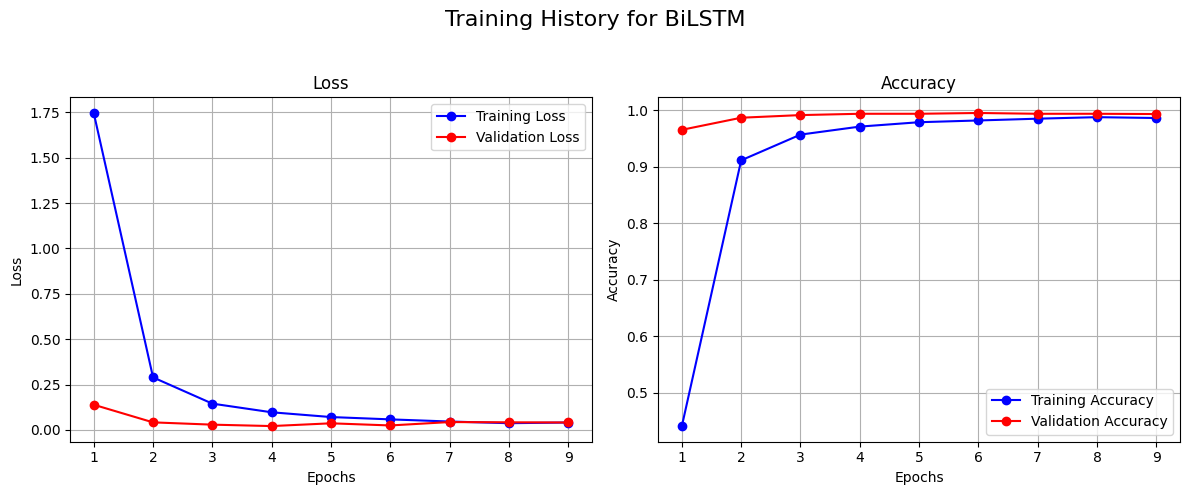

In [12]:
plot_training_history(bilstm_history, model_name="BiLSTM")

In [11]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Embedding,
    Conv1D,
    Bidirectional,
    LSTM,
    Attention,
    GlobalMaxPooling1D,
    Dense,
    Dropout,
    Concatenate
)

# Tham số chính
vocab_size    = len(tokenizer.word_index) + 1
embedding_dim = 128
max_len       = 100
num_classes   = len(np.unique(y_train))

# 1) Input + Embedding
inputs = Input(shape=(max_len,), name="input_ids")
x = Embedding(input_dim=vocab_size,output_dim=embedding_dim,input_length=max_len,name="embedding")(inputs)

# 2) CNN để trích n-gram features
x = Conv1D(filters=128,kernel_size=5,padding="same",activation="relu",name="conv1d")(x)
x = Dropout(0.3, name="dropout_cnn")(x)

# 3) BiLSTM giữ toàn bộ chuỗi (return_sequences=True)
x = Bidirectional(LSTM(64, return_sequences=True), name="bilstm")(x)

# 4) Self-Attention: query/key/value đều là output của BiLSTM
attn_output = Attention(name="self_attention")([x, x])  
# shape = (batch_size, timesteps, units*2)

# 5) Kết hợp BiLSTM + Attention (tùy chọn)
x = Concatenate(name="concat_lstm_attn")([x, attn_output])
# shape = (batch_size, timesteps, units*4)

# 6) Pooling gom thông tin khắp chuỗi
x = GlobalMaxPooling1D(name="global_max_pool")(x)

# 7) Dense layers + Dropout
x = Dense(128, activation="relu", name="dense1")(x)
x = Dropout(0.5, name="dropout_dense1")(x)
x = Dense(64, activation="relu", name="dense2")(x)
x = Dropout(0.5, name="dropout_dense2")(x)
# 8) Output
outputs = Dense(num_classes, activation="softmax", name="output")(x)

# 9) Build & compile
cnn_bilstm_model = Model(inputs, outputs, name="CNN_BiLSTM_Attention")
cnn_bilstm_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["accuracy"]
)

cnn_bilstm_model.summary()


Model: "CNN_BiLSTM_Attention"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)    │ (None, 100)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 100, 128)       │        323,200 │ input_ids[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 100, 128)       │         82,048 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_cnn (Dropout)     │ (None, 100, 128)       │              0 │ conv1d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bilstm (Bidirectional)    │ (None, 100, 128)       │         98,816 │ dropout_cnn[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ self_attention            │ (None, 100, 128)       │              0 │ bilstm[0][0],          │
│ (Attention)               │                        │                │ bilstm[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concat_lstm_attn          │ (None, 100, 256)       │              0 │ bilstm[0][0],          │
│ (Concatenate)             │                        │                │ self_attention[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pool           │ (None, 256)            │              0 │ concat_lstm_attn[0][0] │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense1 (Dense)            │ (None, 128)            │         32,896 │ global_max_pool[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_dense1 (Dropout)  │ (None, 128)            │              0 │ dense1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense2 (Dense)            │ (None, 64)             │          8,256 │ dropout_dense1[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_dense2 (Dropout)  │ (None, 64)             │              0 │ dense2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 27)             │          1,755 │ dropout_dense2[0][0]   │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 546,971 (2.09 MB)

 Trainable params: 546,971 (2.09 MB)

 Non-trainable params: 0 (0.00 B)

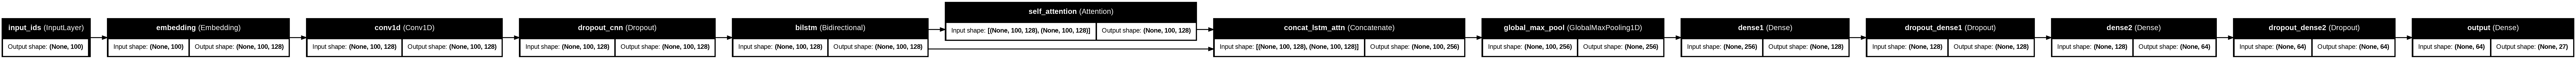

In [12]:
from IPython.display import Image
from tensorflow.keras.utils import plot_model

# Giả sử model của bạn được đặt tên là `model`
# Tham số show_shapes=True để hiển thị kích thước tensor,
# show_layer_names=True để hiển thị tên các layer.
plot_model(
    cnn_bilstm_model,
    to_file='model_architecture.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='LR'      # 'LR' để sơ đồ từ trái qua phải, 'TB' cho từ trên xuống dưới
)

# Vẽ và lưu ra file
plot_model(cnn_bilstm_model, to_file='cnn_bilstm_atention_model.png', show_shapes=True, show_layer_names=True, rankdir='LR')

# Hiển thị ảnh ngay trong notebook
Image('cnn_bilstm_atention_model.png')

In [13]:
#ModelCheckpoint nhằm lưu lại mô hình tại thời điểm có giá trị mất mát trên tập validation thấp nhất
callback_model = tf.keras.callbacks.ModelCheckpoint('/kaggle/working/cnn_bilstm_model.keras', monitor='val_loss')
# Train
cnn_bilstm_history = cnn_bilstm_model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1,callbacks=[early_stop,callback_model])


Epoch 1/30


I0000 00:00:1748573236.583952      92 cuda_dnn.cc:529] Loaded cuDNN version 90300


605/605 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.1925 - loss: 2.6214 - val_accuracy: 0.9279 - val_loss: 0.2830
Epoch 2/30
605/605 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.8431 - loss: 0.4571 - val_accuracy: 0.9860 - val_loss: 0.0651
Epoch 3/30
605/605 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9419 - loss: 0.1857 - val_accuracy: 0.9926 - val_loss: 0.0424
Epoch 4/30
605/605 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9681 - loss: 0.1057 - val_accuracy: 0.9916 - val_loss: 0.0570
Epoch 5/30
605/605 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9742 - loss: 0.0845 - val_accuracy: 0.9926 - val_loss: 0.0567
Epoch 6/30
605/605 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9800 - loss: 0.0604 - val_accuracy: 0.9935 - val_loss: 0.0659
Epoch 7/30
605/605 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9791 - loss: 0.0779 - val_accuracy: 0.9935 - val_loss: 0.0552
Epoch 8/30
605/605 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9835 - loss: 0.0539 - val_accuracy: 0.99

In [14]:
# 2) Đánh giá loss/accuracy chung trên test set (tuỳ chọn)
loss, acc = cnn_bilstm_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f} - Test Accuracy: {acc:.4f}")

# 3) Dự đoán nhãn trên X_test
y_pred_proba = cnn_bilstm_model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# 4) In classification report
report = classification_report(
    y_test,
    y_pred,
    target_names=label_encoder.classes_
)
print( report)

Test Loss: 0.0810 - Test Accuracy: 0.9907
                          precision    recall  f1-score   support

            cancel_order       0.99      0.98      0.99       187
            change_order       0.98      0.97      0.98       187
 change_shipping_address       0.98      0.99      0.99       216
  check_cancellation_fee       0.99      1.00      0.99       199
           check_invoice       0.99      0.97      0.98       192
   check_payment_methods       1.00      1.00      1.00       206
     check_refund_policy       0.99      0.99      0.99       200
               complaint       1.00      1.00      1.00       203
contact_customer_service       1.00      0.99      0.99       208
     contact_human_agent       0.97      1.00      0.98       201
          create_account       0.98      0.99      0.98       217
          delete_account       0.99      0.99      0.99       178
        delivery_options       1.00      1.00      1.00       218
         delivery_period       0.

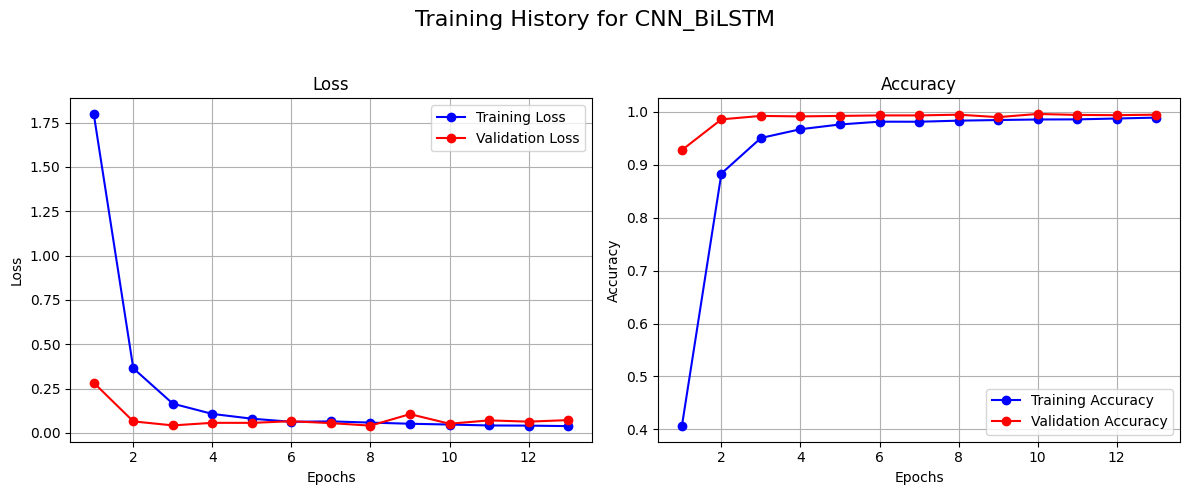

In [15]:
plot_training_history(cnn_bilstm_history, model_name="CNN_BiLSTM")

In [ ]:
import joblib
from tensorflow.keras.models import save_model

# Lưu mô hình CNN
# bilstm.save('bilstm_model.h5')

# Lưu tokenizer
joblib.dump(tokenizer, 'tokenizer.pkl')

# Lưu label_encoder
joblib.dump(label_encoder, 'label_encoder.pkl')


In [ ]:
def chatbot_response(user_input):
     # Tiền xử lý văn bản đầu vào
    user_input = remove_number(user_input)
    user_input = remove_punctuation(user_input)
    user_input = remove_whitespace(user_input)
    user_input = remove_similarletter(user_input)
    user_input = re.sub(emoji_pattern, " ",user_input)

    
    tokens = nltk.word_tokenize(user_input.lower())
    filtered_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in english_stopwords and token.isalpha()]
    cleaned_text = ' '.join(filtered_tokens)

    seq = tokenizer.texts_to_sequences([cleaned_text])
    padded_seq = pad_sequences(seq, maxlen=max_len, padding='post')

    pred = model.predict(padded_seq)
    intent = label_encoder.inverse_transform([np.argmax(pred)])[0]

    responses = df[df['intent'] == intent]['response'].tolist()
    if responses:
        return random.choice(responses)
    else:
        return "I'm not sure how to respond to that."


In [ ]:
# def chatbot_response(user_input):
#     tokens = nltk.word_tokenize(user_input.lower())
#     filtered_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in english_stopwords and token.isalpha()]
#     cleaned_text = ' '.join(filtered_tokens)

#     input_vector = vectorizer.transform([cleaned_text]).toarray()
#     predicted_label = model.predict(input_vector)
#     predicted_intent = label_encoder.inverse_transform([np.argmax(predicted_label)])[0]
    
#     responses = df[df['intent'] == predicted_intent]['response'].tolist()
#     if responses:
#         return random.choice(responses)
#     else:
#         return "I'm not sure how to respond to that."


In [ ]:
print('Hello! I am a chatbot. How can I help you today? Type "quit" to exit.')
while True:
    user_input = input('> ')
    if user_input.lower() == 'quit':
        break
    response = chatbot_response(user_input)
    print(response)

In [ ]:
import os
import pickle


if not os.path.exists('model'):
    os.makedirs('model')

if not os.path.exists('dataset'):
    os.makedirs('dataset')

# Save the trained model
with open('model/chatbot_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Save the vectorizer
with open('model/vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

# Save the intents to the "dataset" folder
with open('dataset/intents.json', 'w') as f:
    json.dump(intents, f)